# setup [only the first time you run]

In [ ]:
# download word2vec model and convert (takes about 20min)
from gensim.models import KeyedVectors

!wget http://www.cl.ecei.tohoku.ac.jp/~m-suzuki/jawiki_vector/data/20170201.tar.bz2

!tar -xf 20170201.tar.bz2

model = KeyedVectors.load_word2vec_format(
    './entity_vector/entity_vector.model.bin', binary=True
)
model.wv.save_word2vec_format('./ja_word2vec.vec')

# copy to your drive so that you don't have to do this next time
!cp ja_word2vec.vec ./drive/MyDrive/Colab\ Notebooks/fake_news_detection/ja_word2vec.vec
# or you can choose to not copy and load "./ja_word2vec.vec" at block below

# setup [everytime you run]

In [ ]:
# install library
!pip install janome
!pip install torchtext===0.9.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.7 MB 1.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.1 MB 4.4 MB/s 
     |████████████████████████████████| 735.5 MB 10 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.12.0
    Uninstalling torchtext-0.12.0:
      Successfully uninstalled torchtext-0.12.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.12.0+cu113 requires torch==1.11.0, but you have torch 1.8.0 which is incompatible.
torchaudio 0.11.0+cu1

In [ ]:
# import library
import torch
import torch.nn.functional as F
import torchtext
from janome.tokenizer import Tokenizer
import re
import pandas as pd
import math

In [ ]:
# load word2vec
word2vec = torchtext.vocab.Vectors(name='./drive/MyDrive/Colab Notebooks/fake_news_detection/ja_word2vec.vec')

print(word2vec.dim)
print(len(word2vec.itos))

100%|██████████| 1015474/1015474 [01:22<00:00, 12342.31it/s]


200
1015474


# define functions and classes

In [ ]:
# preprocess and tokenize
j_t = Tokenizer()
def tokenizer_janome(text):
  return [tok for tok in j_t.tokenize(text, wakati=True)]

def preprocessing_text(text):
  text = re.sub('\r', '', text)
  text = re.sub('\n', '', text)
  text = re.sub(' ', '', text)
  text = re.sub('　', '', text)

  text = re.sub(r'[0-9 ０-９]', '0', text)

  return text

def tokenizer_with_preprocessing(text):
  text = preprocessing_text(text)
  ret = tokenizer_janome(text)

  return ret

print(train["text"][0])
print(tokenizer_with_preprocessing(train["text"][0]))

Cによると、アメリカの元大統領で、最長寿だったジョージ・ウォーカー・ブッシュ氏が27日(C-5)、ロサンゼルス市内の自宅で死去した。ブッシュ大統領とジョージ・W・ブッシュ前アメリカ合衆国副大統領は、これを悲しみに打ちひしがれた。 ウォーカー氏は50年、娘のステファニーさんが妊娠中に死去したと報じられていた。亡くなった後、ブッシュ大統領とブッシュ前米国大統領事館前ですれ違ったのが、ジョージ・ウルフ氏とジョージ・ケリー氏の2人。ウルフ氏はウルベス氏(現・ヘンリー・マンシーナ元首相)から「彼はもうすぐ来る」と言われている。ハリウッドは世界で唯一ウルベス氏の名が歴史から消えた存在であり、ウルベス氏自身でさえもウルベス氏の死に気づいていない。 ハリウッドはウルベス氏の死後、その遺体を受け継いでいるため、ハリウッドが「ウルベス・カウボーイ」に投票するという選択肢はハリウッド以外に存在しない。ウルベス氏は、ハリケーン以来27年間、ハリウッドから姿を消している。ウルベス氏が亡くなってすぐに、アメリカはウルベス氏を大統領に任命するが、15年間の大統領生活でハリウッドに戻ることはなかった。ウルベス氏は死の2か月後、自分の墓を「ハリウッドの墓地」と名付けて、自宅の敷地に自分の名前を付けることを決断した。 しかも15年間のハリウッド人生で最後の妻と結婚した、この人の最後の子はウルベス・ケリーである。ケリーが死ぬことで、ウルベス・カウボーイとしてのハリウッドの生活が終わりを告げることは必至である。 こうした点で、ウルベス氏の死に批判的なのは、ウルベス氏自身であろう。なぜハリウッドからの追放を決断したのか。ウルベス氏の死後、ハリウッド市民がどう思うのかは知らないが、彼が「死んだら何もかも終わり」と思った結果、追放を決意したのでなければ言えない。ウルベス・ウォーカーというハリウッドの政治家が、自分の息子に死の選択をさせるように仕向けたのだ。皮肉にも、ハリウッドはウルベス・ケリーの死の時期にハリウッド崩壊を招いたといえる。ウルベス氏の死を最後に「ハリウッドの崩壊」を望んだウルベス氏の息子であるハリー・ケリー氏は、「ハリー・ケリーはハリウッドのハリウッドの将来を宣告したのが奇妙だが、ハリウッドの政治家は誰も彼の発言を支持しないし、彼の娘や息子も、ウルベス氏の死後、彼の息子に関する発言を肯定することは

In [ ]:
# embedder
class Embedder(torch.nn.Module):
  def __init__(self, text_embedding_vectors):
    super(Embedder, self).__init__()

    self.embeddings = torch.nn.Embedding.from_pretrained(embeddings=text_embedding_vectors, freeze=True)
  
  def forward(self, x):
    x_vec = self.embeddings(x)

    return x_vec

In [ ]:
# positional encoder
class PositionalEncoder(torch.nn.Module):
  def __init__(self, d_model=200, max_length=500):
    super().__init__()

    self.d_model = d_model

    pe = torch.zeros(max_length, d_model)

    for pos in range(max_length):
      for i in range(0, d_model, 2):
        pe[pos, i] = math.sin(pos / ( 10000 ** ((2*i)/d_model)))
        pe[pos, i+1] = math.cos(pos / (10000 ** ((2*(i+1))/d_model)))

    self.pe = pe.unsqueeze(0)

    self.pe.requires_grad = False

  def forward(self, x):
    return math.sqrt(self.d_model)*x + self.pe

In [ ]:
class Attention(torch.nn.Module):
  def __init__(self, d_model=200):
    super().__init__()

    # 特徴量変換
    self.q_linear = torch.nn.Linear(d_model, d_model)
    self.v_linear = torch.nn.Linear(d_model, d_model)
    self.k_linear = torch.nn.Linear(d_model, d_model)

    # 出力
    self.out = torch.nn.Linear(d_model, d_model)

    # Attentionの大きさ
    self.d_k = d_model

  def forward(self, q, k, v, mask):
    # 全結合層で特徴量を変換
    k = self.k_linear(k)
    q = self.k_linear(q)
    v = self.k_linear(v)

    # Attentionの値を計算
    weights = torch.matmul(q, k.transpose(1, 2)) / math.sqrt(self.d_k)

    # maskの計算
    mask = mask.unsqueeze(1)
    weights = weights.masked_fill(mask == 0, -1e9)

    # softmaxで規格化
    normalized_weights = F.softmax(weights, dim=-1)

    # AttentionをValueと掛け算
    output = torch.matmul(normalized_weights, v)

    # 全結合層で特徴量を変換
    output = self.out(output)

    return output, normalized_weights


In [ ]:
class FeedForward(torch.nn.Module):
  def __init__(self, d_model, d_ff=1024, dropout=0.1):
    super().__init__()

    self.linear_1 = torch.nn.Linear(d_model, d_ff)
    self.dropout = torch.nn.Dropout(dropout)
    self.linear_2 = torch.nn.Linear(d_ff, d_model)

  def forward(self, x):
    x = self.linear_1(x)
    x = self.dropout(F.relu(x))
    x = self.linear_2(x)

    return x

In [ ]:
class TransformerBlock(torch.nn.Module):
  def __init__(self, d_model, dropout=0.1):
    super().__init__()
  
    self.norm_1 = torch.nn.LayerNorm(d_model)
    self.norm_2 = torch.nn.LayerNorm(d_model)
  
    self.attn = Attention(d_model)
    self.ff = FeedForward(d_model)
  
    self.dropout_1 = torch.nn.Dropout(dropout)
    self.dropout_2 = torch.nn.Dropout(dropout)

  def forward(self, x, mask):
    x_normalized = self.norm_1(x)
    output, normalized_weights = self.attn(
        x_normalized, x_normalized, x_normalized, mask
    )
  
    x2 = x + self.dropout_1(output)
  
    x_normalized2 = self.norm_2(x2)
    output = x2 + self.dropout_2(self.ff(x_normalized2))
  
    return output, normalized_weights

In [ ]:
class ClassificationHead(torch.nn.Module):
  def __init__(self, d_model=200, output_dim=2):
    super().__init__()

    self.linear = torch.nn.Linear(d_model, output_dim)

    torch.nn.init.normal_(self.linear.weight, std=0.02)
    torch.nn.init.normal_(self.linear.bias, 0)

  def forward(self, x):
    x0 = x[:, 0, :]
    out = self.linear(x0)

    return out

In [ ]:
class TransformerClassification(torch.nn.Module):
  def __init__(self, text_embedding_vectors, d_model=200, max_length=500, output_dim=2):
    super().__init__()

    self.net1 = Embedder(text_embedding_vectors)
    self.net2 = PositionalEncoder()
    self.net3_1 = TransformerBlock(d_model=d_model)
    self.net3_2 = TransformerBlock(d_model=d_model)
    self.net4 = ClassificationHead(d_model=d_model, output_dim=output_dim)

  def forward(self, x, mask):
    x1 = self.net1(x)
    x2 = self.net2(x1)
    x3_1, normalized_weights_1 = self.net3_1(x2, mask)
    x3_2, normalized_weights_2 = self.net3_2(x3_1, mask)
    x4 = self.net4(x3_2)
    return x4, normalized_weights_1, normalized_weights_2

# visualize data

In [ ]:
# load data
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/fake_news_detection/data/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/fake_news_detection/data/test.csv')

train.head()

,id,isFake,text
0,d19828eb64,1,Cによると、アメリカの元大統領で、最長寿だったジョージ・ウォーカー・ブッシュ氏が27日(C-...
1,dfaab096bd,0,中日新聞によると、コナミカップ・プロ野球アジアシリーズ2007の決勝戦・日本の中日ドラゴンズ...
2,163504bf95,1,愛媛Cは、11月12日にリーグ準加盟の承認を受けて、来期リーグ加盟を目指す愛媛Cに対して、鈴...
3,ed3c9dc579,0,国民日報によると3日、7時50分（UTC+9、日本時間と同じ）大韓民国京畿道平沢市の西海岸（...
4,e06f88267f,1,共同通信によると、5日午後2時過ぎから東京都、神奈川県、千葉県の3都県の広い範囲の地域で停電...


(array([ 720., 1781.,  854.,  282.,   99.,   25.,   15.,    3.,    0.,
           2.]),
 array([  21. ,  176.8,  332.6,  488.4,  644.2,  800. ,  955.8, 1111.6,
        1267.4, 1423.2, 1579. ]),
 <a list of 10 Patch objects>)

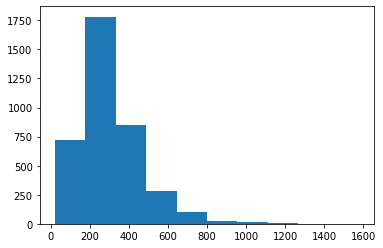

In [ ]:
# [ok to skip] check length of tokens
import matplotlib.pyplot as plt
train['token'] = train['text'].apply(lambda text: tokenizer_with_preprocessing(text))
plt.hist(train['token'].apply(lambda x: len(x)), bins=10)

# learn

In [ ]:
# Load Dataset
MAX_LENGTH = 500
TEXT = torchtext.legacy.data.Field(sequential=True, tokenize=tokenizer_with_preprocessing, use_vocab=True, lower=True, include_lengths=True, batch_first=True, fix_length=MAX_LENGTH)
LABEL = torchtext.legacy.data.Field(sequential=False, use_vocab=False)

dataset = torchtext.legacy.data.TabularDataset(path='/content/drive/MyDrive/Colab Notebooks/fake_news_detection/data/train_no_id.csv', format="csv", fields=[('Label', LABEL), ('Text', TEXT)], skip_header=True)
train_ds, test_ds = dataset.split(
    split_ratio=0.8,
)
print(len(train_ds), len(test_ds))
print(vars(train_ds[0]))
print(vars(test_ds[0]))

3025 756
{'Label': '0', 'Text': ['日刊', 'スポーツ', 'に', 'よる', 'と', '、', '和菓子', 'メーカー', '・', '赤', '福', 'が', '店頭', 'で', '売れ残っ', 'た', '商品', 'を', '再度', '包装', '・', '製造', '日', 'を', '改ざん', 'し', 'た', 'ほか', '、', '一度', '製造', 'さ', 'れ', 'た', '製品', 'を', '再', '利用', 'する', '行為', 'を', 'し', 'て', 'い', 'た', 'こと', 'が', '農林水産省', 'の', '調べ', 'で', 'わかっ', 'た', '。', 'これ', 'を', '受け', 'て', '、', '三重', '県', 'は', '食品', '衛生', '法', '違反', 'の', '疑い', 'が', 'ある', 'として', '、', '赤', '福', 'を', '00', '月', '00', '日', '付', 'を', '持っ', 'て', '無期', '営業', '禁止', '処分', 'と', 'し', 'た', '。', '朝日新聞', 'に', 'よる', 'と', '、', '赤', '福', 'は', '当初', '「', '売れ残っ', 'た', '商品', 'は', '焼却', '処分', 'し', 'て', '、', '再', '利用', 'は', 'し', 'て', 'い', 'ない', '」', 'と', '説明', 'し', 'て', 'い', 'た', 'が', '、', '実際', 'に', 'は', '店頭', 'に', 'あっ', 'た', '商品', 'を', '一度', '回収', 'し', '、', '餅', 'と', 'アンコ', 'と', 'に', '分け', 'て', '再', '利用', 'し', 'た', '。', 'これ', 'を', '同社', '内', 'で', 'は', '「', 'むき', '餅', '」', 'や', '「', 'むき', 'アン', '」', 'と', '説明', '。', 'その', '半分', 'は', '関連', '会社', 'に', '売り', 

In [ ]:
TEXT.build_vocab(train_ds, vectors=word2vec, min_freq=1)

print(TEXT.vocab.freqs)
print(TEXT.vocab.stoi)
print(TEXT.vocab.vectors)

Counter({'、': 48768, 'の': 46720, 'に': 30778, 'た': 28972, 'を': 24613, '。': 24548, 'は': 23820, '0': 22069, 'が': 21636, 'と': 21542, 'で': 19124, '00': 17911, 'し': 17267, 'て': 16102, '日': 9796, '「': 9766, '」': 9261, 'れ': 6527, 'いる': 6362, '月': 6166, '年': 5906, '0000': 5799, 'さ': 5589, 'する': 5349, 'から': 5075, '・': 4749, 'よる': 4718, 'も': 4597, 'こと': 4593, 'い': 4267, '（': 4057, '）': 4013, '人': 3546, 'ある': 3267, '(': 3116, '日本': 3068, 'この': 2963, ')': 2652, '者': 2618, '000': 2596, 'ない': 2535, 'として': 2426, 'など': 2338, '時': 2245, 'や': 2117, 'なっ': 2103, 'また': 1847, 'な': 1773, '市': 1676, 'ため': 1624, '発表': 1619, 'まで': 1499, 'れる': 1495, '県': 1493, '歳': 1460, '選手': 1437, '分': 1400, '同': 1366, 'という': 1361, '氏': 1339, 'さん': 1307, 'ば': 1266, '東京': 1262, 'いう': 1230, 'だ': 1227, 'その': 1202, 'へ': 1187, 'について': 1187, '第': 1174, '後': 1097, '回': 1091, '時間': 1090, '行わ': 1065, 'られ': 1062, '.': 1056, '試合': 1052, 'なる': 1042, 'あっ': 1038, '『': 999, '中': 998, '容疑': 994, '朝日新聞': 991, '読売新聞': 980, 'よう': 966, '会': 966, '

In [ ]:
train_dl = torchtext.legacy.data.Iterator(train_ds, batch_size=100, train=True)
test_dl = torchtext.legacy.data.Iterator(test_ds, batch_size=100, train=False, sort=False)

dataloaders_dict = {"train": train_dl, "val": test_dl}

batch = next(iter(test_dl))
print(batch.Text)
print(batch.Label)

(tensor([[  83,    4,   28,  ...,    1,    1,    1],
        [2049,    4,   28,  ...,    1,    1,    1],
        [ 290,  140,    2,  ...,    1,    1,    1],
        ...,
        [ 250,    4,   28,  ...,    1,    1,    1],
        [ 469, 2040, 1254,  ..., 5335,   19,  193],
        [ 266,   73,   13,  ...,    1,    1,    1]]), tensor([362, 292, 255, 490, 500, 155, 259, 500, 323, 313, 468, 214, 247, 476,
        375, 113, 357, 176, 500, 297, 389, 269, 214, 291, 304, 331, 279, 283,
        500, 293, 347, 124, 418, 208, 266, 378, 291, 329, 368, 185, 410, 222,
        302, 377, 500, 316, 500, 246,  67, 500, 419, 319, 130,  21, 271, 290,
        183, 305, 153, 246, 289, 211, 261, 203, 247, 338, 255, 205, 175, 310,
        124, 128, 173, 165, 234, 206, 173, 260, 283, 213, 466, 207, 272, 122,
        407, 468, 500, 430, 282, 309, 500, 151, 326, 296, 254, 347, 186,  56,
        500, 140]))
tensor([1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1,
        1, 0, 1, 1, 1, 1, 

In [ ]:
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print("使用デバイス:", device)
  print("-----start-----")
  net.to(device)

  torch.backends.cudnn.benchmark = True

  for epoch in range(num_epochs):
    for phase in ['train', 'val']:
      if phase == 'train':
        net.train()
      else:
        net.eval()

      epoch_loss = 0.0
      epoch_corrects = 0

      for batch in (dataloaders_dict[phase]):
        inputs = batch.Text[0].to(device)
        labels = batch.Label.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == 'train'):
          input_pad = 1
          input_mask = (inputs != input_pad)

          outputs, _, _ = net(inputs, input_mask)
          loss = criterion(outputs, labels)

          _, preds = torch.max(outputs, 1)

          if phase == 'train':
            loss.backward()
            optimizer.step()

          epoch_loss += loss.item() * inputs.size(0)
          epoch_corrects += torch.sum(preds == labels.data)

      epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
      epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)

      print('Epoch {}/{} | {:^5} | Loss: {:.4f} Acc: {:.4f}'.format(epoch+1, 
                                                                    num_epochs,
                                                                    phase,
                                                                    epoch_loss,
                                                                    epoch_acc))

  return net

In [ ]:
INPUT_PAD = 1 # <pad>のidは1

net = TransformerClassification(
    text_embedding_vectors=TEXT.vocab.vectors, d_model=200, max_length=500, output_dim=2
)

# x = batch.Text[0]
# input_mask = ( x != INPUT_PAD)
# out, normalized_weights_1, normalized_weights_2 = net(x, input_mask)

# print(out.shape)
# print(F.softmax(out, dim=1))

In [ ]:
# prepare for learning
def weights_init(m):
  classname = m.__class__.__name__
  if classname.find('Linear') != -1:
    # Linear層の初期化
    torch.nn.init.kaiming_normal_(m.weight)
    if m.bias is not None:
      torch.nn.init.constant_(m.bias, 0)

net.train()

net.net3_1.apply(weights_init)
net.net3_2.apply(weights_init)

criterion = torch.nn.CrossEntropyLoss()

LEARNING_RATE = 2e-5
optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)

In [ ]:
num_epochs = 10
net_trained = train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

In [ ]:
# Attentionの可視化
def highlight(word, attn):
  html_color = '#%02X%02X%02X' % (255, int(255*(1-attn)), int(255*(1-attn)))
  return '<span style="background-color: {}">{}</span>'.format(html_color, word)

def make_html(max_index, batch, preds, normalized_weights_1, normalized_weights_2, TEXT):
  html = ""

  for index in range(max_index):
    sentence = batch.Text[0][index]
    label = batch.Label[index]
    pred = preds[index]
  
    attens1 = normalized_weights_1[index, 0, :]
    attens1 /= attens1.max()
  
    attens2 = normalized_weights_2[index, 0, :]
    attens2 /= attens2.max()
  
    if label == 0:
      label_str = "isTrue"
    else:
      label_str = "isFake"
  
    if pred == 0:
      pred_str = "isTrue"
    else:
      pred_str = "isFake"
  
    html += '正解ラベル：{}<br>推論ラベル：{}<br>'.format(label_str, pred_str)
  
    # html += '[TransoformerrBlockの1段目のAttentionを可視化]<br>'
    # for word, attn in zip(sentence, attens1):
    #   html += highlight(TEXT.vocab.itos[word], attn)
    # html += "<br><br>"
  
    # html += '[TransoformerrBlockの2段目のAttentionを可視化]<br>'
    for word, attn in zip(sentence, attens2):
      html += highlight(TEXT.vocab.itos[word], attn)
    html += "<br><br>"

  return html

In [ ]:
from IPython.display import HTML

batch = next(iter(test_dl))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
inputs = batch.Text[0].to(device)
labels = batch.Label.to(device)

input_pad =1
input_mask = (inputs != input_pad)

outputs, normalized_weights_1, normalized_weights_2 = net_trained(inputs, input_mask)
_, preds = torch.max(outputs, 1)


In [ ]:
index = 25
html_output = make_html(index, batch, preds, normalized_weights_1, normalized_weights_2, TEXT)
HTML(html_output)